In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from torchvision import transforms
import torchvision.transforms.functional as TF
import ipywidgets as widgets
from PIL import Image as pilImage
from pathlib import Path
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import sys
sys.path.append("../") 
sys.path.append("../neural_style") 
%load_ext autoreload
%autoreload 2
from neural_style.neural_style import *

ROOT_DIR =  Path('../')
DATA_PATH = ROOT_DIR/'data/'
IMGS_PATH = ROOT_DIR/'images/'
MODEL_PATH = ROOT_DIR/'models/'

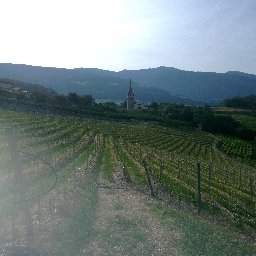

In [8]:
img_path = IMGS_PATH/'content-images/weingart_bright.jpg'
img = pilImage.open(img_path)
img.resize((256,256),pilImage.NEAREST)

In [76]:
device = torch.device("cpu")

content_image = utils.load_image(img_path, scale=4)
content_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])
content_image = content_transform(content_image)
content_image = content_image.unsqueeze(0).to(device)
content_image.shape

torch.Size([1, 3, 992, 744])

In [42]:
with torch.no_grad():
    style_model = TransformerNet()
    state_dict = torch.load(MODEL_PATH/'candy.pth')
    # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
    for k in list(state_dict.keys()):
        if re.search(r'in\d+\.running_(mean|var)$', k):
            del state_dict[k]
    style_model.load_state_dict(state_dict)
    style_model.to(device)

    output = style_model(content_image).cpu()

In [15]:
output.shape

torch.Size([1, 3, 496, 372])

CPU times: user 1.19 s, sys: 150 ms, total: 1.34 s
Wall time: 1.08 s


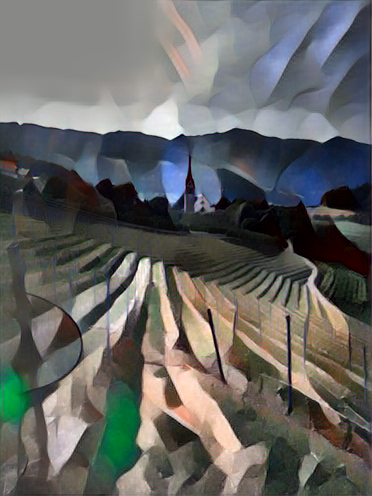

In [24]:
with torch.no_grad():
    output = style_model(content_image).cpu()
img = output[0].clone().clamp(0, 255).numpy()
img = img.transpose(1, 2, 0).astype("uint8")
img = pilImage.fromarray(img)
img

In [68]:
np.array(pilImage.open(img_path).convert('RGB').resize((200, 100), pilImage.ANTIALIAS)).shape

(100, 200, 3)

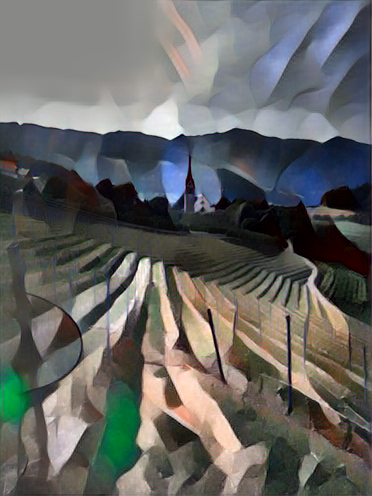

In [27]:
from ipywidgets import interact
def style_img(content_image):
    with torch.no_grad():
        output = style_model(content_image).cpu()
    img = output[0].clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype("uint8")
    img = pilImage.fromarray(img)
    display(img)
style_img(content_image)

In [38]:
def cut_img(img,h_s,h_e,w_s,w_e):
    return content_image[:,:,h_s:h_e,w_s:w_e]

In [57]:
from collections import namedtuple
nt = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'])

In [58]:
tt = nt(0,1,2,3)

In [62]:
tt.relu2_2

1

In [77]:
style_cut = lambda h_s,h_e,w_s,w_e: style_img(cut_img(content_image,h_s,h_e,w_s,w_e))

In [78]:
interact(style_cut,
        h_s=widgets.IntSlider(min=0, max=content_image.shape[2], step=10, value=0),
        h_e=widgets.IntSlider(min=0, max=content_image.shape[2], step=10, value=content_image.shape[2]),
        w_s=widgets.IntSlider(min=0, max=content_image.shape[3], step=10, value=0),
        w_e=widgets.IntSlider(min=0, max=content_image.shape[3], step=10, value=content_image.shape[3]))

interactive(children=(IntSlider(value=0, description='h_s', max=992, step=10), IntSlider(value=992, descriptio…

<function __main__.<lambda>(h_s, h_e, w_s, w_e)>

## Training

In [ ]:
fake_argparse = namedtuple('fake_argparse',['style_image', 'style_size', 'image_size', 'batch_size', 'content_weight', 'style_weight'])
args = fake_argparse(style_image)

In [ ]:
batch_size = 4
dataset_path = 
device = torch.device("cuda" if args.cuda else "cpu")
np.random.seed(0)
torch.manual_seed(0)

transform = transforms.Compose([
    transforms.Resize(args.image_size),
    transforms.CenterCrop(args.image_size),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])
train_dataset = datasets.ImageFolder(dataset_path, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

In [ ]:


transformer = TransformerNet().to(device)
optimizer = Adam(transformer.parameters(), args.lr)
mse_loss = torch.nn.MSELoss()

vgg = Vgg16(requires_grad=False).to(device)
style_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])
style = utils.load_image(args.style_image, size=args.style_size)
style = style_transform(style)
style = style.repeat(args.batch_size, 1, 1, 1).to(device)

features_style = vgg(utils.normalize_batch(style))
gram_style = [utils.gram_matrix(y) for y in features_style]

for e in range(args.epochs):
    transformer.train()
    agg_content_loss = 0.
    agg_style_loss = 0.
    count = 0
    for batch_id, (x, _) in enumerate(train_loader):
        n_batch = len(x)
        count += n_batch
        optimizer.zero_grad()

        x = x.to(device)
        y = transformer(x)

        y = utils.normalize_batch(y)
        x = utils.normalize_batch(x)

        features_y = vgg(y)
        features_x = vgg(x)

        content_loss = args.content_weight * mse_loss(features_y.relu2_2, features_x.relu2_2)

        style_loss = 0.
        for ft_y, gm_s in zip(features_y, gram_style):
            gm_y = utils.gram_matrix(ft_y)
            style_loss += mse_loss(gm_y, gm_s[:n_batch, :, :])
        style_loss *= args.style_weight

        total_loss = content_loss + style_loss
        total_loss.backward()
        optimizer.step()

        agg_content_loss += content_loss.item()
        agg_style_loss += style_loss.item()

        if (batch_id + 1) % args.log_interval == 0:
            mesg = "{}\tEpoch {}:\t[{}/{}]\tcontent: {:.6f}\tstyle: {:.6f}\ttotal: {:.6f}".format(
                time.ctime(), e + 1, count, len(train_dataset),
                              agg_content_loss / (batch_id + 1),
                              agg_style_loss / (batch_id + 1),
                              (agg_content_loss + agg_style_loss) / (batch_id + 1)
            )
            print(mesg)

        if args.checkpoint_model_dir is not None and (batch_id + 1) % args.checkpoint_interval == 0:
            transformer.eval().cpu()
            ckpt_model_filename = "ckpt_epoch_" + str(e) + "_batch_id_" + str(batch_id + 1) + ".pth"
            ckpt_model_path = os.path.join(args.checkpoint_model_dir, ckpt_model_filename)
            torch.save(transformer.state_dict(), ckpt_model_path)
            transformer.to(device).train()

# save model
transformer.eval().cpu()
save_model_filename = "epoch_" + str(args.epochs) + "_" + str(time.ctime()).replace(' ', '_') + "_" + str(
    args.content_weight) + "_" + str(args.style_weight) + ".model"
save_model_path = os.path.join(args.save_model_dir, save_model_filename)
torch.save(transformer.state_dict(), save_model_path)

print("\nDone, trained model saved at", save_model_path)